In [1]:
# create a character level Fuel dataset from text file

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
import os
import codecs
import subprocess
from subprocess import Popen, PIPE, STDOUT
from toolz import merge

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

import numpy as np
from abc import ABCMeta, abstractmethod
from toolz import merge
import pandas as pd
from six import add_metaclass
from picklable_itertools.extras import equizip
from blocks.bricks.recurrent import (GatedRecurrent, Bidirectional)
from blocks.initialization import IsotropicGaussian, Constant, Orthogonal
import theano
import theano.tensor as T

from blocks.bricks import Initializable
from blocks.bricks.base import application, Brick, lazy
from blocks.bricks import Tanh, Linear, MLP
from blocks.bricks.lookup import LookupTable
from blocks.bricks.parallel import Fork
from blocks.utils import (shared_floatx_nans, dict_union)
from blocks.roles import add_role, WEIGHT
from blocks.bricks import Tanh, Linear, Softmax, MLP
from blocks.extensions.saveload import Checkpoint


from fuel.datasets import TextFile
from fuel.schemes import ConstantScheme
from fuel.streams import DataStream
from fuel.transformers import (
    Merge, Batch, Filter, Padding, SortMapping, Unpack, Mapping)

DEBUG:root:test


In [3]:
# path to your training data
TRAINING_DATASET = '/home/chris/projects/machine_learning/dcu-character-lms/data/paul_graham_essays.train.txt'
DEV_DATASET = '/home/chris/projects/machine_learning/dcu-character-lms/data/paul_graham_essays.dev.txt'

UNKNOWN_TOKEN = '|'
EOS_TOKEN = '`'

In [4]:
def get_vocab(dataset):
    all_symbols = set()
    with codecs.open(dataset, encoding='utf8') as inp: 
        for l in inp.read().strip().split('\n'):
            all_symbols.update(l)
    return all_symbols
    
    
def get_y_file(dataset):
    
    # a file to hold the Y representation of the dataset
    y_tmp_file = os.path.join(os.path.basename(dataset), dataset+'_temp_y.txt')
    
    with codecs.open(dataset, encoding='utf8') as inp:
        with codecs.open(
            y_tmp_file, 'wb',encoding='utf8') as y_out:
            for l in inp.read().strip().split('\n'):
                y_seq = l[1:] + EOS_TOKEN
                assert len(l) == len(y_seq)
    
                y_out.write(''.join(y_seq) + '\n')

    return y_tmp_file

In [5]:
class CharTextFile(TextFile):
    def __init__(self, *args, **kwargs):
        super(CharTextFile, self).__init__(*args, **kwargs)
    
    # override parent method to only do rstrip instead of strip
    def get_data(self, state=None, request=None):
        if request is not None:
            raise ValueError
        sentence = next(state)
        if self.preprocess is not None:
            sentence = self.preprocess(sentence)
        data = [self.dictionary[self.bos_token]] if self.bos_token else []
        if self.level == 'word':
            data.extend(self.dictionary.get(word,
                                            self.dictionary[self.unk_token])
                        for word in sentence.split())
        else:
            data.extend(self.dictionary.get(char,
                                            self.dictionary[self.unk_token])
                        for char in sentence.rstrip())
        if self.eos_token:
            data.append(self.dictionary[self.eos_token])
        return (data,)

In [6]:
# add an unknown token in case we observe a new character at prediction time
vocab = get_vocab(TRAINING_DATASET)
vocab.update([UNKNOWN_TOKEN, EOS_TOKEN])
word2idx = {v:k for k,v in enumerate(vocab)}

idx2word = {v:k for k,v in word2idx.items()}

In [7]:
from fuel.datasets import TextFile
from fuel.schemes import ConstantScheme
from fuel.streams import DataStream
from fuel.transformers import (
    Merge, Batch, Filter, Padding, SortMapping, Unpack, Mapping)


# axis swapping so that we get (time, batch, features)
def swapaxes(data):
    """Switch the axes in the sequence parts of the data tuple"""
    return tuple(array.swapaxes(0,1) for array in data)

class _too_long(object):
    """Filters sequences longer than given sequence length."""
    def __init__(self, seq_len=50):
        self.seq_len = seq_len

    def __call__(self, sentence_pair):
        return all([len(sentence) <= self.seq_len
                    for sentence in sentence_pair])


def get_stream(vocab, x_file,
               seq_len=50, batch_size=20, sort_k_batches=5, unk_token="`", **kwargs):
    """Prepares the data stream."""
    
    y_file = get_y_file(x_file)

    def _length(item):
        """Item is assumed to be (x,y)"""
        return len(item[0])
    
    # Get text files from both source and target
    X = CharTextFile([x_file], vocab, bos_token=None, eos_token=None,
                 unk_token=unk_token, level='character')

    Y = CharTextFile([y_file], vocab, bos_token=None, eos_token=None,
                 unk_token=unk_token, level='character')

    # Merge them to get x1, x2 pairs
    stream = Merge([X.get_example_stream(),
                    Y.get_example_stream()],
                    ('x', 'y'))

    # Filter sequences that are too long
    stream = Filter(stream, predicate=_too_long(seq_len=seq_len))

    # LOOKAHEAD SORT
    # Build a batched version of stream to read k batches ahead
#     stream = Batch(stream,
#                    iteration_scheme=ConstantScheme(
#                    batch_size*sort_k_batches))
    
    # Sort all samples in the read-ahead batch
#     stream = Mapping(stream, SortMapping(_length))

    # Convert it into a stream again
#     stream = Unpack(stream)
    # END LOOKAHEAD SORT

    # Construct batches from the stream with specified batch size
    stream = Batch(
        stream, iteration_scheme=ConstantScheme(batch_size))

    # Pad sequences that are short
    masked_stream = Padding(stream)
    
    # transpose tensors to get (time, batch, features)
    masked_stream = Mapping(masked_stream, swapaxes)

    return masked_stream

In [8]:
# def get_stream(vocab, x_file, y_file,
#                seq_len=50, batch_size=20, sort_k_batches=5, unk_token="`", **kwargs):

BATCH_SIZE = 10
MAX_SEQ_LEN = 200

train_stream = get_stream(word2idx, TRAINING_DATASET, batch_size=BATCH_SIZE, seq_len=MAX_SEQ_LEN)
dev_stream = get_stream(word2idx, DEV_DATASET, batch_size=BATCH_SIZE)

In [9]:
j = 0 
for tx, tx_mask, ty, ty_mask in list(train_stream.get_epoch_iterator()):
    l = len([idx2word[i] for i in tx[:, 0]])
    if l == 19:
        print(j)
    j += 1
    print(tx.shape)
    print(ty.shape)
    if tx.shape != ty.shape:
        print('ERROR')
        print(j)
        print(tx.shape)
        print(ty.shape)

(95, 10)
(95, 10)
(99, 10)
(99, 10)
(96, 10)
(96, 10)
(94, 10)
(94, 10)
(88, 10)
(88, 10)
(98, 10)
(98, 10)
(79, 10)
(79, 10)
(83, 10)
(83, 10)
(97, 10)
(97, 10)
(81, 10)
(81, 10)
(98, 10)
(98, 10)
(88, 10)
(88, 10)
(81, 10)
(81, 10)
(93, 10)
(93, 10)
(90, 10)
(90, 10)
(91, 10)
(91, 10)
(97, 10)
(97, 10)
(89, 10)
(89, 10)
(96, 10)
(96, 10)
(93, 10)
(93, 10)
(97, 10)
(97, 10)
(75, 10)
(75, 10)
(94, 10)
(94, 10)
(96, 10)
(96, 10)
(97, 10)
(97, 10)
(87, 10)
(87, 10)
(93, 10)
(93, 10)
(87, 10)
(87, 10)
(91, 10)
(91, 10)
(95, 10)
(95, 10)
(98, 10)
(98, 10)
(86, 10)
(86, 10)
(89, 10)
(89, 10)
(89, 10)
(89, 10)
(95, 10)
(95, 10)
(93, 10)
(93, 10)
(96, 10)
(96, 10)
(95, 10)
(95, 10)
(97, 10)
(97, 10)
(92, 10)
(92, 10)
(75, 10)
(75, 10)
(92, 10)
(92, 10)
(85, 10)
(85, 10)
(88, 10)
(88, 10)
(92, 10)
(92, 10)
(92, 10)
(92, 10)
(97, 10)
(97, 10)
(96, 10)
(96, 10)
(92, 10)
(92, 10)
(96, 10)
(96, 10)
(98, 10)
(98, 10)
(96, 10)
(96, 10)
(93, 10)
(93, 10)
(98, 10)
(98, 10)
(90, 10)
(90, 10)
(96, 10)
(

In [10]:
# Create the Model

class RNNLM(Initializable):
    """Model for character level LM"""

    def __init__(self, vocab_size, embedding_dim, state_dim, output_dim, **kwargs):
        super(RNNLM, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.state_dim = state_dim
        self.output_dim = output_dim

#         self._sequence_names = list(transition.apply.sequences)
#         self._state_names = list(transition.apply.states)
#         self._context_names = list(transition.apply.contexts)
        
        self.lookup = LookupTable(name='embeddings')
        self.transition = GatedRecurrent(activation=Tanh(), dim=state_dim)
        
        self.fork = Fork(
            [name for name in self.transition.apply.sequences
             if name != 'mask'], prototype=Linear(), name='fork')

        # output layer -- this may need to be changed
        self.output_layer = Linear(name='output_layer')
        
        self.children = [self.lookup, self.transition,
                         self.fork, self.output_layer]


    def _push_allocation_config(self):
        self.lookup.length = self.vocab_size
        self.lookup.dim = self.embedding_dim

        self.fork.input_dim = self.embedding_dim
        self.fork.output_dims = [self.transition.get_dim(name)
                                 for name in self.fork.output_names]
        
        self.output_layer.input_dim = self.state_dim
        self.output_layer.output_dim = self.output_dim

    def cost(self, x, x_mask, y, y_mask):
        
        representation = self.lookup.apply(x)
        
        states = self.transition.apply(**merge(self.fork.apply(representation, as_dict=True), {'mask': x_mask}))
        
        # get cost from output layer, transform inputs as necessary
        states_shape = states.shape
        states_dim1 = states_shape[0] * states_shape[1]
        states_dim2 = states_shape[2]

        y_hat = Softmax().apply(
            self.output_layer.apply(states.reshape((states_dim1, states_dim2))))

        y_preds = y_hat.argmax(axis=1)

        y = y.flatten()
        costs = T.nnet.categorical_crossentropy(y_hat, y)

        flat_y_mask = y_mask.flatten()

        # here we are zeroing the fake costs for masked parts of the predictions, and dividing by the number of actual
        # instances
        final_cost = T.sum(costs * flat_y_mask) / T.sum(flat_y_mask)
        
        return final_cost
    
    # TODO: really we should just compute one step of the recurrent transition each time,
    # but that means we are going to scan over sample instead, so we are adding another "layer" 
    # to the recurrent transition
    # we want to implement a repeated sampling process where the output is fed back in
    # this is also probably @recurrent
    # remember: n_steps, iterate=False
    
    # We need to add the output to the states of this transition -- can be done using the @sample.delegate
    # decorator
    
# FROM NMT decoder model
#         @application
#     def generate(self, source_sentence, representation, **kwargs):
#         return self.sequence_generator.generate(
#             n_steps=2 * source_sentence.shape[1],
#             batch_size=source_sentence.shape[0],
#             attended=representation,
#             attended_mask=tensor.ones(source_sentence.shape).T,
#             **kwargs)
    
    
    
#     @recurrent
#     def sample(previous_output, sample_length=10):
#         """Sample from the model
        
#         x: int -- the seed character
        
#         """
        
#         # wrap start_x to make dims correct
# #         x = np.array([start_x]).reshape((1, 1))
        
        
        
#         for t in range(sample_length):
#             representation = self.lookup.apply(current_seq)

#             states = self.transition.apply(**merge(self.fork.apply(representation, as_dict=True)))

#             last_state = states[-1]
            
#             # get cost from output layer, transform inputs as necessary
# #             states_shape = states.shape
# #             states_dim1 = states_shape[0] * states_shape[1]
# #             states_dim2 = states_shape[2]

#             y_hat = Softmax().apply(
#                 self.output_layer.apply(last_state))

#             # TODO: get a random sample parameterized by softmax distribution
#             y_pred = y_hat.argmax(axis=1)
# #             current_seq.concatenate(y_pred, axis=)
            
#         return current_seq
    
    
#  current_states = self.transition.apply(
#             iterate=False, as_list=True,
#             **dict_union(sequences, kwargs))
    
    # Chris: Note the `recurrent` annotation here
#     @recurrent
#     def generate(self, outputs, **kwargs):
#         """A sequence generation step.

#         Chris: how can we constrain this step to use the target word input at the current timestep?

#         Parameters
#         ----------
#         outputs : :class:`~tensor.TensorVariable`
#             The outputs from the previous step.

#         Notes
#         -----
#         The contexts, previous states and glimpses are expected as keyword
#         arguments.

#         """
#         states = dict_subset(kwargs, self._state_names)
#         # masks in context are optional (e.g. `attended_mask`)
#         # contexts = dict_subset(kwargs, self._context_names, must_have=False)
        

#         next_glimpses = self.transition.take_glimpses(
#             as_dict=True, **dict_union(states, glimpses, contexts))
#         next_readouts = self.readout.readout(
#             feedback=self.readout.feedback(outputs),
#             **dict_union(states, next_glimpses, contexts))
#         next_outputs = self.readout.emit(next_readouts)
#         next_costs = self.readout.cost(next_readouts, next_outputs)
#         next_feedback = self.readout.feedback(next_outputs)
#         next_inputs = (self.fork.apply(next_feedback, as_dict=True)
#                        if self.fork else {'feedback': next_feedback})
#         next_states = self.transition.compute_states(
#             as_list=True,
#             **dict_union(next_inputs, states, next_glimpses, contexts))
#         return (next_states + [next_outputs] +
#                 list(next_glimpses.values()) + [next_costs])

#     @generate.delegate
#     def generate_delegate(self):
#         return self.transition.apply

#     @generate.property('states')
#     def generate_states(self):
#         return self._state_names + ['outputs']

#     @generate.property('outputs')
#     def generate_outputs(self):
#         return (self._state_names + ['outputs'] +
#                 self._glimpse_names + ['costs'])
        

In [11]:
VOCAB_SIZE = len(word2idx)
STATE_DIM=100
EMBEDDING_DIM=52
OUTPUT_DIM=len(word2idx)
SAVE_PATH='test_model_checkpoint'

test_rnnlm = RNNLM(VOCAB_SIZE, EMBEDDING_DIM, STATE_DIM, OUTPUT_DIM)

In [12]:
# initialize for testing
test_rnnlm.weights_init = IsotropicGaussian(0.1)
test_rnnlm.biases_init = Constant(0)
test_rnnlm.push_initialization_config()
test_rnnlm.initialize()

In [13]:
# Make symbolic variables
x = T.lmatrix("x")
x_mask = T.matrix("x_mask")
y = T.lmatrix("y")
y_mask = T.matrix("y_mask")

cost = test_rnnlm.cost(x, x_mask, y, y_mask)
cost.name = 'minibatch_cost'

# test_cost_func = theano.function([x, x_mask, y, y_mask], test_val)

In [14]:
import pprint

from blocks.monitoring import aggregation
from blocks.graph import ComputationGraph, apply_noise
from blocks.model import Model
from blocks.algorithms import (GradientDescent, Scale,
                               StepClipping, CompositeRule, AdaDelta, Adam)
from blocks.extensions.monitoring import TrainingDataMonitoring, DataStreamMonitoring
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing, Timing
from blocks.extensions.stopping import FinishIfNoImprovementAfter
from blocks.graph import apply_dropout, apply_noise

# create the Blocks main loop
cost_cg = ComputationGraph(cost)
model = Model(cost)

algorithm = GradientDescent(
    cost=cost, parameters=cost_cg.parameters,
    step_rule=CompositeRule([StepClipping(1.),
                             AdaDelta()])
)

parameters = model.get_parameter_dict()
logger.info("Parameters:\n" +
                pprint.pformat(
                    [(key, value.get_value().shape) for key, value in parameters.items()],
                    width=120))

# Note that observables also get added to the log -- this is useful for post-processing
observables = [cost]


extensions = [
#     Timing(every_n_batches=1),
    TrainingDataMonitoring(observables, after_batch=True),
    DataStreamMonitoring(
        [cost],
        data_stream=dev_stream,
        prefix="valid",
        every_n_batches=10
    ),
    FinishAfter(after_n_batches=100),
    Printing(every_n_batches=1, after_epoch=False),
    Checkpoint(SAVE_PATH, every_n_batches=100, save_separately=['log'])
]


main_loop = MainLoop(
    model=model,
    data_stream=train_stream,
    algorithm=algorithm,
    extensions=extensions
)

main_loop.run()


INFO:blocks.algorithms:Taking the cost gradient
INFO:blocks.algorithms:The cost gradient computation graph is built
INFO:root:Parameters:
[('/output_layer.b', (52,)),
 ('/gatedrecurrent.initial_state', (100,)),
 ('/fork/fork_gate_inputs.b', (200,)),
 ('/fork/fork_gate_inputs.W', (52, 200)),
 ('/fork/fork_inputs.b', (100,)),
 ('/fork/fork_inputs.W', (52, 100)),
 ('/embeddings.W', (52, 52)),
 ('/gatedrecurrent.state_to_gates', (100, 200)),
 ('/gatedrecurrent.state_to_state', (100, 100)),
 ('/output_layer.W', (100, 52))]
DEBUG:blocks.monitoring.evaluators:variable to evaluate: minibatch_cost
DEBUG:blocks.monitoring.evaluators:Using the default  (average over minibatches) aggregation scheme for minibatch_cost
DEBUG:blocks.monitoring.evaluators:Compiling initialization and readout functions
DEBUG:blocks.monitoring.evaluators:Initialization and readout functions compiled
DEBUG:blocks.monitoring.evaluators:variable to evaluate: minibatch_cost
DEBUG:blocks.monitoring.evaluators:Compiling initi


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 valid_minibatch_cost: 3.95278811455


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 1
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1:
	 minibatch_cost: 3.95370554924


-----------------------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 9
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 9:
	 minibatch_cost: 3.48032522202


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 10
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 10:
	 minibatch_cost: 3.27284049988
	 valid_minibatch_cost: 3.24759292603


----------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 19
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 19:
	 minibatch_cost: 3.02148342133


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 20
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 20:
	 minibatch_cost: 2.98765850067
	 valid_minibatch_cost: 3.08249235153


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 29
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 29:
	 minibatch_cost: 3.02762246132


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 30
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 30:
	 minibatch_cost: 2.99631357193
	 valid_minibatch_cost: 3.03388547897


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 39
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 39:
	 minibatch_cost: 2.96629405022


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 40
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 40:
	 minibatch_cost: 2.94725823402
	 valid_minibatch_cost: 2.98470449448


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 49
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 49:
	 minibatch_cost: 2.87337255478


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 50
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 50:
	 minibatch_cost: 2.86586356163
	 valid_minibatch_cost: 2.9433016777


---------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 59
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 59:
	 minibatch_cost: 2.82209253311


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 60
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 60:
	 minibatch_cost: 2.91804623604
	 valid_minibatch_cost: 2.8881881237


---------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 69
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 69:
	 minibatch_cost: 2.75048947334


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 70
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 70:
	 minibatch_cost: 2.71329331398
	 valid_minibatch_cost: 2.80474162102


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 79
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 79:
	 minibatch_cost: 2.72320485115


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 80
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 80:
	 minibatch_cost: 2.69310736656
	 valid_minibatch_cost: 2.75777173042


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 89
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 89:
	 minibatch_cost: 2.62500596046


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 90
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 90:
	 minibatch_cost: 2.60757708549
	 valid_minibatch_cost: 2.68048667908


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 99
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 99:
	 minibatch_cost: 2.67812466621




/home/chris/programs/anaconda/lib/python2.7/site-packages/blocks/serialization.py:85: UserWarning: WARNING: Main loop depends on the function `RNNLM` in `__main__` namespace.

Because of limitations to pickling, this means that you will not be able to resume your model outside of a namespace containing this function. In other words, you can only call `continue_training` from within this script.
  MAIN_MODULE_WARNING.format(kwargs.get('name', obj.__name__))
/home/chris/programs/anaconda/lib/python2.7/site-packages/blocks/serialization.py:85: UserWarning: WARNING: Main loop depends on the function `swapaxes` in `__main__` namespace.

Because of limitations to pickling, this means that you will not be able to resume your model outside of a namespace containing this function. In other words, you can only call `continue_training` from within this script.
  MAIN_MODULE_WARNING.format(kwargs.get('name', obj.__name__))


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 100:
	 minibatch_cost: 2.6717004776
	 training_finish_requested: True
	 valid_minibatch_cost: 2.63111042976


-------------------------------------------------------------------------------
TRAINING HAS BEEN FINISHED:
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 100:
	 minibatch_cost: 2.6717004776


/home/chris/programs/anaconda/lib/python2.7/site-packages/blocks/serialization.py:85: UserWarning: WARNING: Main loop depends on the function `_too_long` in `__main__` namespace.

Because of limitations to pickling, this means that you will not be able to resume your model outside of a namespace containing this function. In other words, you can only call `continue_training` from within this script.
  MAIN_MODULE_WARNING.format(kwargs.get('name', obj.__name__))
/home/chris/programs/anaconda/lib/python2.7/site-packages/blocks/serialization.py:85: UserWarning: WARNING: Main loop depends on the function `CharTextFile` in `__main__` namespace.

Because of limitations to pickling, this means that you will not be able to resume your model outside of a namespace containing this function. In other words, you can only call `continue_training` from within this script.
  MAIN_MODULE_WARNING.format(kwargs.get('name', obj.__name__))


In [15]:
# visualize cost on train and dev over time
import cPickle

# inspect and visualize the log of a blocks experiment

LOG_LOCATION= SAVE_PATH + '_log'

text_offset = 200

def visualize_log(log_location, title="test"):
    log = cPickle.load(open(log_location))
    all_keys = set()
    for t in log.keys():
        all_keys.update(log[t].keys())
    
    print(all_keys)
    interesting_keys = ['minibatch_cost', 'valid_minibatch_cost']

    all_points = []
    mins = []
    maxs = []
    for idx, key in enumerate(interesting_keys): 
        points = [(i, log[i][key]) for i in log.keys() if key in log[i]]
        min_val, max_val = (min(points, key=lambda x: x[1]), max(points, key=lambda x: x[1]))
        mins.append(min_val)
        maxs.append(max_val)
        print('key: {}, min = {}, max = {}'.format(key, min_val, max_val))
        all_points.append(points)
    
    fig, ax = plt.subplots()

    for i,key_points in enumerate(all_points):
        name = interesting_keys[i]
        x,y = zip(*key_points)
        plt.plot(x, y, label=name)
        ax.scatter(mins[i][0], mins[i][1], s=70, c='red')
        ax.annotate('{}:{}'.format(mins[i][0], round(mins[i][1],3)), xy=(mins[i][0]+text_offset, mins[i][1]))
        ax.annotate('{}:{}'.format(maxs[i][0], round(maxs[i][1],3)), xy=(maxs[i][0]+text_offset, maxs[i][1]))
        ax.scatter(maxs[i][0], maxs[i][1], s=70, c='green')
    plt.legend(loc=4)     
    plt.title(title, fontsize=28)
    plt.show()

set(['training_finish_requested', 'saved_to', 'valid_minibatch_cost', 'training_finished', 'minibatch_cost'])
key: minibatch_cost, min = (97, array(2.5285205841064453, dtype=float32)), max = (1, array(3.9537055492401123, dtype=float32))
key: valid_minibatch_cost, min = (100, array(2.631110429763794, dtype=float32)), max = (0, array(3.9527881145477295, dtype=float32))


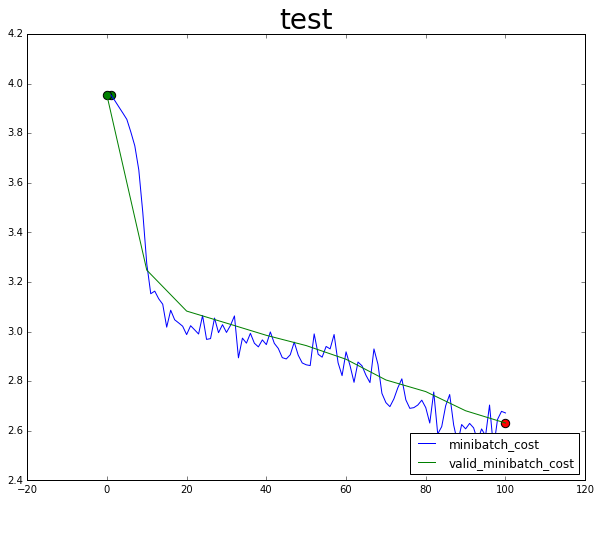

In [16]:
visualize_log(LOG_LOCATION)

In [81]:
# IDEA: compile two theano funcs that give us what we need, then iterate through the recurrent transitions manually
# func one: compute a prediction and an output for one step of the recurrent transition
# if this is the first step, we need to get the initial state, otherwise use the previous state

# add_role(self.parameters[2], INITIAL_STATE)



# one step from the beginning
def one_step(x_i, h0):

#     x = tensor.lmatrix('x')
#     gi = tensor.matrix('gi')
    
    
    representation = test_rnnlm.lookup.apply(x)
    inputs, gate_inputs = test_rnnlm.fork.apply(test_rnnlm.lookup.apply(x))
    inputs = inputs[0]
    gate_inputs = gate_inputs[0]
    
    states = test_rnnlm.transition.apply(inputs, gate_inputs, h0, iterate=False)
                                         
    # get cost from output layer
    output = test_rnnlm.output_layer.apply(states)
    
    y_hat = Softmax().apply(output)
    y_preds = y_hat.argmax(axis=1)
    
    return y_preds
    
#     h1 = test_rnnlm.apply(x, gi, h0, iterate=False)
#     next_h = theano.function(inputs=[h0, x, gi], outputs=[h1])

#     h0_val = 0.1 * numpy.array([[1, 1, 0], [0, 1, 1]],
#                                dtype=theano.config.floatX)
#     x_val = 0.1 * numpy.array([[1, 2, 3], [4, 5, 6]],
#                               dtype=theano.config.floatX)
#     zi_val = (h0_val + x_val) / 2
#     ri_val = -x_val
#     W_val = 2 * numpy.ones((3, 3), dtype=theano.config.floatX)

#     z_val = numpy.tanh(h0_val.dot(W_val) + zi_val)
#     r_val = numpy.tanh(h0_val.dot(W_val) + ri_val)
#     h1_val = (z_val * numpy.tanh((r_val * h0_val).dot(W_val) + x_val) +
#               (1 - z_val) * h0_val)
#     assert_allclose(
#         h1_val, next_h(h0_val, x_val, numpy.hstack([zi_val, ri_val]))[0],
#         rtol=1e-6)


In [82]:
h0 = T.matrix('h0')

one_step_out = one_step(x, h0)

test_f = theano.function([x, h0], one_step_out)

In [87]:
word2idx['t']

45

In [86]:
test_h0 = test_rnnlm.transition.parameters[2].get_value()[None, :]
test_x = np.array([[45]])

best_next_char = int(test_f(test_x, test_h0))
idx2word[best_next_char]
best_next_char

38

In [28]:
test_rnnlm.transition.parameters[2].get_value().shape

(100,)

In [72]:
test_ff = theano.function([x], test_rnnlm.lookup.apply(x))

In [73]:
inputs, gate_inputs = test_rnnlm.fork.apply(test_rnnlm.lookup.apply(x))

In [74]:
inputs = inputs[0]
gate_inputs = gate_inputs[0]

In [75]:
states = test_rnnlm.transition.apply(inputs, gate_inputs, h0, iterate=False)

In [76]:
state_func = theano.function([x, h0], states)

In [77]:
test_h0 = test_rnnlm.transition.parameters[2].get_value()[None, :]
test_x = np.array([[26]])

state_func(test_x, test_h0)

array([[ 0.15337265,  0.35798132, -0.03531885,  0.18557921, -0.08655842,
         0.20255089,  0.28872693, -0.29286978,  0.33033705,  0.0659342 ,
         0.46630245,  0.21770398, -0.37381312, -0.38199341, -0.21020369,
        -0.19557318, -0.17720565,  0.18718858,  0.07564428, -0.33102953,
         0.19538087,  0.03622055,  0.28203675, -0.06454989, -0.14904541,
        -0.17863753,  0.25632882,  0.2258707 , -0.31578323,  0.26739722,
        -0.33664936,  0.01170724,  0.3577036 , -0.07073875,  0.23685446,
         0.32173142,  0.08102061, -0.26142463,  0.39205122,  0.07891752,
         0.20339084, -0.3481304 ,  0.17199868, -0.24260682,  0.30408949,
         0.13543908,  0.27734071,  0.24665681,  0.15021122,  0.12408364,
         0.17467679,  0.12253734,  0.08632198,  0.04989602,  0.21178529,
        -0.23456544,  0.1086115 , -0.02538755,  0.08242612, -0.25234541,
        -0.29412743,  0.02206928, -0.07791054,  0.370588  ,  0.12026836,
         0.03632174,  0.11247357, -0.03117642,  0.3

In [66]:
t_fff = theano.function([x], [inputs, gate_inputs])

In [67]:
ip, gi = t_fff(test_x)

In [63]:
t_fff(test_x)

{'gate_inputs': array([[[ -5.29192239e-02,   2.16913983e-01,  -9.17408392e-02,
           -1.05395392e-01,  -9.94189084e-03,   1.01206064e-01,
           -7.95359910e-03,  -3.18370461e-02,   1.50757402e-01,
           -8.21331292e-02,   1.11832857e-01,  -1.64771359e-02,
            7.88120851e-02,   2.21751899e-01,  -1.71842992e-01,
           -9.92188826e-02,   1.22901015e-01,   1.25320122e-01,
            1.92447841e-01,   4.13261726e-03,   9.64488536e-02,
            4.19272035e-02,   2.82580014e-02,  -5.71969673e-02,
           -5.33812083e-02,  -9.12458897e-02,   1.02144144e-01,
            5.70465848e-02,  -1.39211770e-02,   8.24904218e-02,
           -1.98895410e-02,   2.70863742e-01,   1.31288007e-01,
            2.06264153e-01,   1.51097760e-01,   2.27982644e-02,
            1.48788616e-01,  -9.06664729e-02,  -6.25096262e-04,
           -5.09598330e-02,  -8.32446665e-03,  -1.63697079e-03,
            6.87555298e-02,   1.24091715e-01,  -4.64278162e-02,
           -8.41709822e-0

In [56]:
test_ff(test_x).shape

(1, 1, 52)

In [30]:
word2idx['c']

26

In [34]:

test_h0 = test_rnnlm.transition.parameters[2].get_value()[None, :]

test_x.shape
# test_f(test_x, test_h0)

(1, 1)

In [ ]:
# from blocks tests
def test_one_step(self):
    h0 = tensor.matrix('h0')
    x = tensor.matrix('x')
    gi = tensor.matrix('gi')
    h1 = self.gated.apply(x, gi, h0, iterate=False)
    next_h = theano.function(inputs=[h0, x, gi], outputs=[h1])

    h0_val = 0.1 * numpy.array([[1, 1, 0], [0, 1, 1]],
                               dtype=theano.config.floatX)
    x_val = 0.1 * numpy.array([[1, 2, 3], [4, 5, 6]],
                              dtype=theano.config.floatX)
    zi_val = (h0_val + x_val) / 2
    ri_val = -x_val
    W_val = 2 * numpy.ones((3, 3), dtype=theano.config.floatX)

    z_val = numpy.tanh(h0_val.dot(W_val) + zi_val)
    r_val = numpy.tanh(h0_val.dot(W_val) + ri_val)
    h1_val = (z_val * numpy.tanh((r_val * h0_val).dot(W_val) + x_val) +
              (1 - z_val) * h0_val)
    assert_allclose(
        h1_val, next_h(h0_val, x_val, numpy.hstack([zi_val, ri_val]))[0],
        rtol=1e-6)

In [ ]:
# WORKING: implement sampling from the model 
# outputs of self.sampling_fn:
_1, outputs, _2, _3, costs = (self.sampling_fn(inp[None, :]))
outputs = outputs.flatten()
costs = costs.T




model_sample = test_rnnlm.sample(x, sample_length=10)

sample = theano.function([x], model_sample)